(640, 640, 3)


/Users/sanketh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app


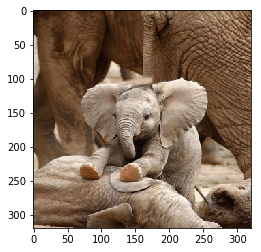

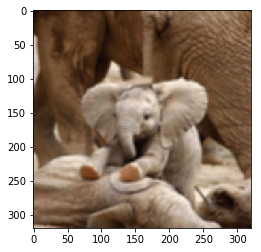

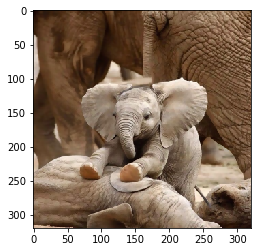

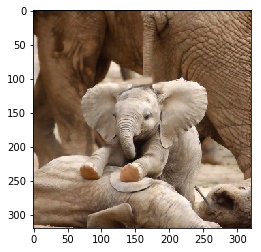

In [2]:
import imageio
import cv2    
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image

def distance(x, y, p, q): # Distance Function between two points- Euclidean
    return np.sqrt((x-p)**2 + (y-q)**2)

def gaussian(x, sigma): # Gaussian Function with zero mean and variance sigma
    return (1.0 /np.sqrt(2 * math.pi * (sigma ** 2)))* math.exp(- (x ** 2) / (2 * sigma ** 2))

def weight(image,i,j,k,l,sigma_c,sigma_d): # Weight function to calculate the gaussians across variation in pixel positions and intensities
	fg = gaussian(image[k][l] - image[i][j], sigma_c) # Function to spread the image intensities across a window in a gaussian curve
	gs = gaussian(distance(i, j, k, l), sigma_d) # Function to spread the varaition in pixel positions from a particular pixel across a window in a gaussian curve
	w = fg * gs	# Dot product of the two functions
	return w

bgr = cv2.imread('babyelephant.jpg') # Reading the image
print(bgr.shape)
bgr1=cv2.resize(bgr,None,fx=0.5, fy=0.5, interpolation= cv2.INTER_CUBIC) # Downsampling it for faster computation
blur = cv2.GaussianBlur(bgr1,(5,5),10) # Applying Gaussian Blur across it with (one case) kernel size 5x5 and sigma 10
cv2.imwrite("original_image.png", bgr1) # Saving the original image
cv2.imwrite("Guassian_blurred_image.png", blur) # Saving the blurred image

''' Function to calculate the Bilateral filter'''''
def designed_bilateral_filter(image,d,sigma_c,sigma_d): # Takes parameters-Image, Window Diameter, Variance across color, Variance across distance
	b,g,r = cv2.split(image) # Splitting the image into Red, green & blue channels
	bilatb=np.zeros(b.shape)
	bilatg=np.zeros(g.shape)
	bilatr=np.zeros(r.shape)

	m= int((d-1)/2) # Radius calulation, ie, distance form the center pixel to the corresponding window
	for i in range(m,b.shape[0]-m): # Starting window at pixel position (m,m) so as to avoid corners
		for j in range(m,b.shape[1]-m):
			Wp1=0 # Total weight initlaized to zero every-time the window moves to next pixel
			Wp2=0
			Wp3=0		
			for k in range(i-m,m+i+1):		# Window function of diameter 'd'
				for l in range(j-m,m+j+1):		
					#print(weight(i,j,k,l))				
					Wp1+=weight(b,i,j,k,l,sigma_c,sigma_d) # Calculation of weight function across each channel and adding all of them up (In a particular Window)
					Wp2+=weight(g,i,j,k,l,sigma_c,sigma_d)
					Wp3+=weight(r,i,j,k,l,sigma_c,sigma_d)				
					bilatb[i,j]+=b[k,l]*weight(b,i,j,k,l,sigma_c,sigma_d) # Calculation of denoised pixel at position (i,j) accross every channel 
					bilatg[i,j]+=g[k,l]*weight(g,i,j,k,l,sigma_c,sigma_d)
					bilatr[i,j]+=r[k,l]*weight(r,i,j,k,l,sigma_c,sigma_d)
					if (k==m+i) and (l==m+j):
						bilatb[i,j]=int(round(bilatb[i,j]/Wp1)) # At the end of the window, we must divide by the total wweight function across every pixel in that window.
						bilatg[i,j]=int(round(bilatg[i,j]/Wp2))
						bilatr[i,j]=int(round(bilatr[i,j]/Wp3))
    # This is to take care of the corner pixels, just replacing the zeros with the corresponding pixel values across the channels'''
	for i in range(0,m):
		for j in range(0,b.shape[1]):
			bilatb[i,j]=b[i,j]
		bilatg[i,j]=g[i,j]
		bilatr[i,j]=r[i,j]
	for i in range(b.shape[0]-m-1,b.shape[0]):
		for j in range(0,b.shape[1]):
			bilatb[i,j]=b[i,j]
			bilatg[i,j]=g[i,j]
			bilatr[i,j]=r[i,j]
	for i in range(0,b.shape[0]):
		for j in range(0,m):
			bilatb[i,j]=b[i,j]
			bilatg[i,j]=g[i,j]
			bilatr[i,j]=r[i,j]
	for i in range(0,b.shape[0]):
		for j in range(b.shape[1]-m-1,b.shape[1]):
			bilatb[i,j]=b[i,j]
			bilatg[i,j]=g[i,j]
			bilatr[i,j]=r[i,j]

	bilat1 = np.zeros(image.shape) # Stacking all the channels in matrix
	bilat1[..., 0] = bilatb # Red Matrix
	bilat1[..., 1] = bilatg # Green Matrix
	bilat1[..., 2] = bilatr # Red Matrix
	return bilat1

bilat = designed_bilateral_filter(bgr1,5,30,10) # Bilateral Filtered Image with filter size 5x5, variace across color=30, variance across distance=10 

#bilat1=cv2.resize(bilat,None,fx=2, fy=2, interpolation= cv2.INTER_CUBIC)

cv2.imwrite("Denoised_image_BI.png", bilat.astype('uint8')) # Saving the image


filtered_image_OpenCV = cv2.bilateralFilter(bgr1, 5, 30, 10) # Bilaterally filtered image by OpenCV

cv2.imwrite("Denoised_image_OpenCV.png",filtered_image_OpenCV)

plt.imshow(cv2.cvtColor(bgr1.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(blur.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(filtered_image_OpenCV.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(bilat.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.show()